# Notebook to Test the Deployed the YoloV8 Model to the Sagemaker Endpoint

## Import Dependencies

In [1]:
import numpy as np
import os
import boto3
from sagemaker.pytorch import PyTorchPredictor
from sagemaker import s3
from sagemaker.deserializers import JSONDeserializer
import time
import cv2
from matplotlib import pyplot as plt
import random

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


## Define the parameters

In [2]:
ENDPOINT_NAME = 'yolo-endpoint'

## Check Creation of Sagemaker Endpoint

In [3]:
sm_client = boto3.client(service_name="sagemaker")

endpoint_created = False
while True:
    response = sm_client.list_endpoints()
    for ep in response['Endpoints']:
        print(f"Endpoint Status = {ep['EndpointStatus']}")
        if ep['EndpointName']==ENDPOINT_NAME and ep['EndpointStatus']=='InService':
            endpoint_created = True
            break
    if endpoint_created:
        break
    time.sleep(5)

Endpoint Status = InService


## Create the Predictor

In [4]:
predictor = PyTorchPredictor(endpoint_name=ENDPOINT_NAME, deserializer=JSONDeserializer())

## List the Class Labels

In [5]:
class_labels = {0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mouse',
 65: 'remote',
 66: 'keyboard',
 67: 'cell phone',
 68: 'microwave',
 69: 'oven',
 70: 'toaster',
 71: 'sink',
 72: 'refrigerator',
 73: 'book',
 74: 'clock',
 75: 'vase',
 76: 'scissors',
 77: 'teddy bear',
 78: 'hair drier',
 79: 'toothbrush'}

## Test The Predictor on a Sample Input

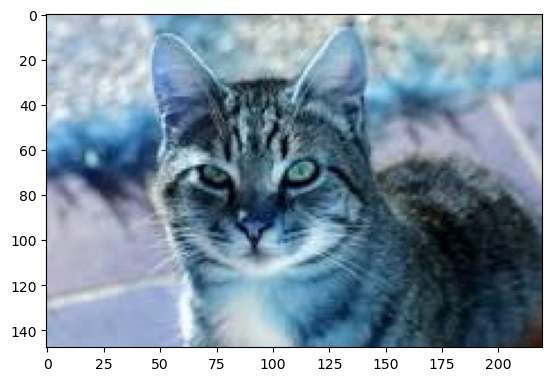

In [6]:
img = cv2.imread('../img/cat.jpg')
plt.imshow(img)

In [7]:
image_height, image_width, _ = img.shape
model_height, model_width = 300, 300
x_ratio = image_width/model_width
y_ratio = image_height/model_height

In [8]:
resized_image = cv2.resize(img, (model_height, model_width))
payload = cv2.imencode('.jpg', resized_image)[1].tobytes()
result = predictor.predict(payload)

In [9]:
if 'boxes' in result:
    for idx,(x1,y1,x2,y2,conf,lbl) in enumerate(result['boxes']):
        print(class_labels[lbl], conf*100)

cat 88.5692298412323


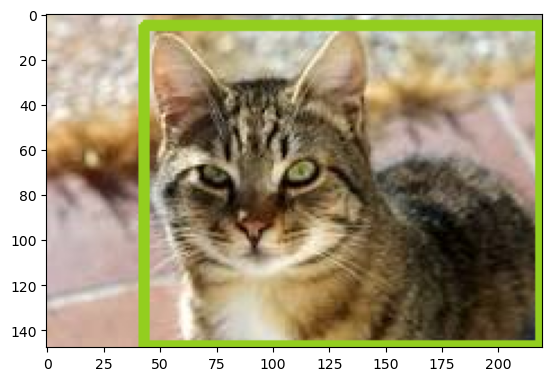

In [10]:
if 'boxes' in result:
    for idx,(x1,y1,x2,y2,conf,lbl) in enumerate(result['boxes']):
        x1, x2 = int(x_ratio*x1), int(x_ratio*x2)
        y1, y2 = int(y_ratio*y1), int(y_ratio*y2)
        color = (random.randint(10,255), random.randint(10,255), random.randint(10,255))
        cv2.rectangle(img, (x1,y1), (x2,y2), color, 4)
        cv2.putText(img, f"Class: {int(lbl)}", (x1,y1-40), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
        cv2.putText(img, f"Conf: {int(conf*100)}", (x1,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
        if 'masks' in result:
            mask = cv2.resize(np.asarray(result['masks'][idx]), dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            for c in range(3):
                img[:,:,c] = np.where(mask>0.5, img[:,:,c]*(0.5)+0.5*color[c], img[:,:,c])

if 'probs' in result:
    lbl = result['probs'].index(max(result['probs']))
    color = (random.randint(10,255), random.randint(10,255), random.randint(10,255))
    cv2.putText(img, f"Class: {int(lbl)}", (20,20), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## Delete Unwated Files and Folders

In [11]:
root = "./"
for path, subdirs, files in os.walk(root):
    for name in files:
        file_path = os.path.join(path, name)
        if "__pycache__" in file_path or ".ipynb_checkpoints" in file_path or ".DS_Store" in file_path:
            os.remove(file_path)